In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [2]:
np.random.seed(42)

# Portfolio Planner

In this activity, you will use the iexfinance api to grab historical data for a 60/40 portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [3]:
import alpaca_trade_api as tradeapi
from dotenv import load_dotenv
load_dotenv()
alpaca_api_key = os.getenv("APCA_API_KEY")
alpaca_secret_key = os.getenv("APCA_SECRET_KEY")
api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')


# Data Collection

In this step, you will need to use the IEX api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [4]:
tickers = ["SPY", "AGG"]
# YOUR CODE HERE
timeframe = '1D'
portfolio_df = pd.DataFrame()
end_date = datetime.now()
start_date = end_date + timedelta(-365)
portfolio_df = api.get_barset(
    tickers,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df
portfolio_df.drop(columns=['open', 'high', 'low', 'volume'], level=1, inplace=True)
portfolio_df.head()

,AGG,SPY
,close,close
2019-11-22 00:00:00-05:00,112.850,311.00
2019-11-25 00:00:00-05:00,112.980,313.35
2019-11-26 00:00:00-05:00,113.120,314.02
2019-11-27 00:00:00-05:00,112.995,315.46
2019-11-29 00:00:00-05:00,112.925,314.27


# Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:
1. Calculate the daily returns for the SPY and AGG closing prices.
2. Calculate volatility for both the SPY and AGG closing prices.
3. Find the last day's closing price for both stocks and save those as variables.
4. Run a Monte Carlo Simulation of at least 500 iterations and generate at least 30 years of closing prices

### HINTS:
There are 252 trading days per year, so the number of records to generate for each Monte Carlo run will be 252 days * 30 years

In [5]:
# Calculate the daily roi for the stocks
# YOUR CODE HERE
daily_returns = portfolio_df.pct_change().dropna()
daily_returns_AGG = daily_returns.mean()['AGG']['close']
daily_returns_SPY = daily_returns.mean()['SPY']['close']

In [6]:
# Calculate volatility
# YOUR CODE HERE
AGG_std = daily_returns.std()['AGG']['close']
SPY_std = daily_returns.std()['SPY']['close']

In [7]:
# Save the last day's closing price
# YOUR CODE HERE
AGG_last_day_closing = portfolio_df['AGG']['close'][-1]
SPY_last_day_closing = portfolio_df['SPY']['close'][-1]

In [25]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252*30
monte_carlo = pd.DataFrame()
portfolio_returns = pd.DataFrame()
weight = [0.6,0.4]


In [26]:
# Run the Monte Carlo Simulation
for x in range(number_simulations):
    
    simulated_AGG_prices = [AGG_last_day_closing]
    simulated_SPY_prices = [SPY_last_day_closing]
    for i in range(number_records):
        simulated_AGG_price = simulated_AGG_prices[-1] * (1 + np.random.normal(daily_returns_AGG, AGG_std))
        simulated_SPY_price = simulated_SPY_prices[-1] * (1 + np.random.normal(daily_returns_AGG, SPY_std))
        
        simulated_AGG_prices.append(simulated_AGG_price)
        simulated_SPY_prices.append(simulated_SPY_price)
    monte_carlo["AGG prices"] = pd.Series(simulated_AGG_prices)
    monte_carlo["SPY prices"] = pd.Series(simulated_SPY_prices)
    daily_returns = monte_carlo.pct_change()
    portfolio_daily_returns = daily_returns.dot(weight)
    portfolio_daily_returns = portfolio_daily_returns.fillna(0)
    portfolio_returns[x] = (1 + portfolio_daily_returns).cumprod()
        
portfolio_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.997705,0.998014,0.998448,0.980456,1.012042,0.972345,0.995279,1.000537,1.013401,0.987763,...,1.002025,1.004522,1.017407,1.006052,1.023237,0.984476,0.998456,0.985454,1.001273,1.001935
2,0.980058,1.022718,1.006118,0.972162,1.020886,0.990582,0.989303,1.009660,1.014617,0.994283,...,1.010105,1.010355,1.026845,1.030853,1.029329,0.957270,1.000182,0.978487,1.006514,0.997685
3,0.972332,1.028851,0.994812,0.974053,1.011254,0.996349,0.987610,1.002490,1.042816,0.998038,...,1.017501,1.003419,1.028373,1.022927,1.010213,0.942132,1.014155,0.978674,1.006454,0.977533
4,0.977185,1.019922,0.986494,0.957576,1.005685,1.006182,0.972677,1.005994,1.043141,1.006076,...,1.002193,0.997800,1.031814,1.024545,1.001561,0.955140,1.000218,0.973580,1.015383,0.970200


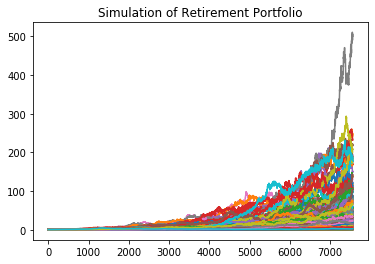

In [29]:
# Visualize the Simulation
# YOUR CODE HERE
plot_title = f"Simulation of Retirement Portfolio"
portfolio_returns.plot(legend=None, title=plot_title)

In [34]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
# YOUR CODE HERE
last_row_30 = portfolio_returns.iloc[-1, :]
last_row_30.head()

0     5.941226
1     1.857776
2    18.190093
3    25.642938
4     7.470806
Name: 7560, dtype: float64

In [36]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
# YOUR CODE HERE
last_row_20 = portfolio_returns.iloc[252*20,:]
last_row_20.head()

0     1.839915
1     1.803248
2     4.007963
3    10.557438
4     2.024512
Name: 5040, dtype: float64

In [43]:
# Display the 90% confidence interval for the ending returns
# YOUR CODE HERE
confidence_interval_30 = last_row_30.quantile(q=[0.05,0.95])
confidence_interval_20 = last_row_20.quantile(q= [0.05,0.95])

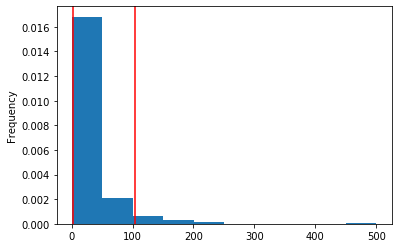

In [57]:
# Visualize the distribution of the ending returns
# YOUR CODE HERE
last_row_30.plot(kind ='hist', bins = 10, density = True)
plt.axvline(confidence_interval_30.iloc[0], color='r')
plt.axvline(confidence_interval_30.iloc[1], color='r')

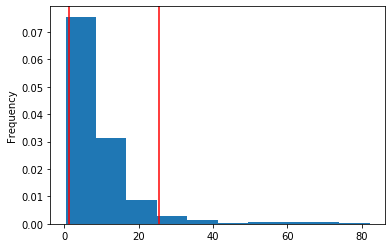

In [56]:
last_row_20.plot(kind= 'hist', bins = 10, density = True)
plt.axvline(confidence_interval_20.iloc[0], color='r')
plt.axvline(confidence_interval_20.iloc[1], color='r')

---

# Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?
2. Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?
3. Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?
4. How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [62]:
# YOUR CODE HERE
print(f"Expected portfolio return for 30 years for 10%: {round(np.percentile(last_row_30,10),2)}.")
print(f"Expected portfolio return for 30 years for 50%: {round(np.percentile(last_row_30,50),2)}.")
print(f"Expected portfolio return for 30 years for 90%: {round(np.percentile(last_row_30,90),2)}.")

Expected portfolio return for 30 years for 10%: 3.09.
Expected portfolio return for 30 years for 50%: 15.57.
Expected portfolio return for 30 years for 90%: 70.63.


### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [63]:
# YOUR CODE HERE
initial_investment = 20000
cumulative_per = initial_investment * last_row_30
print(f"Expected portfolio return at 10%: ${round(np.percentile(cumulative_per,10),2)}.")
print(f"Expected portfolio return at 50%: ${round(np.percentile(cumulative_per,50),2)}.")
print(f"Expected portfolio return at 90%: ${round(np.percentile(cumulative_per,90),2)}.")


Expected portfolio return at 10%: $61853.29.
Expected portfolio return at 50%: $311381.32.
Expected portfolio return at 90%: $1412559.48.


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [72]:
# YOUR CODE HERE
amount_withdraw = 0.04*(round(np.percentile(cumulative_per,10),2))
yearly_income=6085
if amount_withdraw >= yearly_income:
    print(f"4% withdraw is sufficient to cover the projected annual income of ${yearly_income}")
else:
    print(f"4% withdraw is not sufficient to cover the projected annual income of ${yearly_income}")


4% withdraw is not sufficient to cover the projected annual income of $6085


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [73]:
# YOUR CODE HERE
increased_investment = (1.50) * initial_investment
new_cumulative = cumulative_per * increased_investment
new_withdrawal = 0.04*(round(np.percentile(new_cumulative,10),2))
projected_yearly_income=6085
if new_withdrawal >= projected_yearly_income:
    print(f"4% withdraw is sufficient to cover the annual income of ${yearly_income}")
else:
    print(f"4% withdraw is not sufficient to cover the annual income of ${yearly_income}")


4% withdraw is sufficient to cover the annual income of $6085


### Optional Challenge

In this section, you will calculate and plot the cumulative returns for the median and 90% confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [ ]:
# YOUR CODE HERE
